# Lab Assignment Five: Evaluation and Multi-Layer Perceptron
## Rupal Sanghavi, Omar Roa, Van Tran
# Business Case
This dataset represents the responses from students and their friends(ages 15-30, henceforth stated as "young people") of a Statistics class from the Faculty of Social and Economic Sciences at The Comenius University in Bratislava, Slovakia. Their survey was a mix of various topics.

* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

The dataset can be found here. https://www.kaggle.com/miroslavsabo/young-people-survey

Our target is to predict how likely a young person would have an interest in PC Software and Hardware. According to Time Magazine (http://time.com/4433964/teens-social-media-advertising/), "YouTube has become so saturated with popular vloggers that marketers are now turning to so-called "micro-influencers" with smaller but more devoted followings, while agencies are shifting their ad dollars from television to YouTube."

What is a "micro-influencer"? "A micro-influencer is usually Instafamous or a Youtube sensation with a relatively high social following who they have a great impact on." (https://www.bcsagency.com/news/step-aside-bloggers-its-time-for-micro-influencers-to-take-the-stage) According to Digiday (http://digiday.com/marketing/micro-influencers/), if a content creator with a large audience promotes a product, there is a chance that only a small subset of their audience is interested. A "micro-influencer" would likely have an audience that we mostly interested in a product placement by their trusted "micro-influencer".

PC Software and Hardware is the classifier that we chose for this project, but there are various other interests in our dataset (Socializing, Dancing, Art) that could be predicted. The point is to gauge interest in a particular topic, hire a "micro-influencer" to generate content for that topic, and include product placement.

As for how well this should perform? We weren't able to find many articles talking specifically about an algorithm to predict sales trends, but the market is certainly interested. 

* https://www.emarketer.com/Article/Marketers-Turn-Algorithms-Improve-Attribution/1014463
* https://martechtoday.com/algorithms-advertising-7-steps-introducing-ai-marketing-195037
* https://hbr.org/2015/06/the-perils-of-algorithm-based-marketing

We would like our ensemble to perform at least as well as a single classifier based on our scoring function.

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import make_scorer
from scipy.special import expit
import time
import math
import random
from memory_profiler import memory_usage
from sklearn import metrics as mt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from scipy import interp

target_classifier = 'PC'
df = pd.read_csv('responses.csv', sep=",")

## Preparation

In [2]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

Our dataset (1010 rows and 150 columns) was mostly ordinal data as numbers (preferences ranked 1-5) . We also had some ordinal data as strings. 

e.g.
How much time do you spend online?: No time at all - Less than an hour a day - Few hours a day - Most of the day

We first removed any rows which contained NaN values for our target classifer, Shopping centres. Afterwards we imputed mean values for any NaN values in other features. We decided to impute due to the fact that there were not many NaN values in our features compared to the size of our data set. (At most was 20 for a feature, as shown above). We then one-hot encoded any string object, which created extra features.

We are left with numerical values for our features and a size of 1004 x 173

# Evaluation
## Metrics to Evaluate Algorithm's Generalization Performance

In [3]:
# Research on Cost Matrix
# http://www.ibm.com/support/knowledgecenter/SSEPGG_11.1.0/com.ibm.im.model.doc/c_cost_matrix.html

cost_matrix = np.matrix([[0,1,2,3,4],
[1,0,1,2,3],
[3,1,0,1,2],
[5,3,1,0,1],
[7,5,2,1,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

confusion_scorer = make_scorer(get_confusion_costTot, greater_is_better=False)
confusion_scorer

make_scorer(get_confusion_costTot, greater_is_better=False)

We created a cost matrix with advice from IBM's Knowledge Center. We heavily weighted having a false negative due to wasting money on someone who likely would not have interest in the topic and therefore not engage with the micro-influencer. A false positive carries a higher weight than most but is still not the most severe because the money spent on a micro-influencer is still not not wasted due to their more niche topics capturing audiences.
The elements closer to a false negative are weighed heavier than the rest of the elements, which carry a weight of 1*d where d is the distance from the diagonal. We thought values with less confusion should carry less weight.
We then multiply each element in our confusion matrix by the corresponding element in the cost matrix. This means that correct predictions will have no weight, but wrong predictions will carry some weight as discussed above.
Finally, we sum the elements of the new matrix, and use that score as a way to determine performance. The lower the score, the less wrong predictions were made.

## Divide Data into Training and Testing

In [4]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the labels we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

X = X/5
num_folds = 10

cv_object = StratifiedKFold(n_splits= num_folds, random_state=None, shuffle=True)
cv_object.split(X,y)

print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


Even though our data is not imbalanced, We are using Stratified K Fold as our cross-validation object. Scikit's page states "each set contains approximatesly the same percentage of samples of each target class as the complete set. This is important as we want to represent the dataset as accurately as possible. Kfolds also includes all our data over the course of the folds, so we know that all our data is being used at some point.

For this K Fold, we chose the number 10, because it's a large number of datasets to validate our model, but a the same time we do not have to wait an eternity to validate the model.


In [5]:
for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

# Modeling

In [6]:
clf = MLPClassifier()

In [40]:
from sklearn.ensemble import BaggingClassifier
from statistics import mode

class MyEnsemble():
    
    def __init__(self, c, num_c, max_s, v):
        self.Ensemble = BaggingClassifier(base_estimator= c,
                                    n_estimators = num_c,
                                     max_samples = max_s,
                                     verbose = v)
    def predict(self, X):
        return self.Ensemble.predict(X)
    
    def fit(self, X,y):
        self.Ensemble.fit(X,y)
        
    def fit_random(self, X, y):
        self.fit(X,y) # just to get the ensemble estimators initialized
        for classifier in self.Ensemble.estimators_:
            self.fit(X,y)
            row_indexes = np.random.randint(X.shape[0], size=self.Ensemble.max_samples) # gets row indexes
            column_indexes = np.random.randint(X.shape[1], size=math.sqrt(X.shape[1])) #gets column indexes
            classifier.fit(X[np.ix_(row_indexes,column_indexes)], y[row_indexes])
            
    def predict_random(self, x):
        predictions = []
        for classifier in self.Ensemble.estimators_:
            predictions.append[classifier.predict(x)]
        return(mode(predictions))
            
    
    def predict_proba(self, X):
        return self.Ensemble.predict_proba(X)

We implemented randomized feature selection here. 

In [16]:
num_estimators = 20

ensemble = MyEnsemble(clf, num_estimators ,y_train.shape[0],False)
ensemble.fit(X_train,y_train)
ensemble_y_hat = ensemble.predict(X_test)

print(mt.confusion_matrix(ensemble_y_hat,y_test))

[[ 2  2  2  1  0]
 [ 6 11  8  3  2]
 [ 4  6  6  8  4]
 [ 0  1  7  0  3]
 [ 1  0  2  8 11]]


In [17]:
ensemble.predict_proba(X_test)

array([[ 0.1922528 ,  0.28378675,  0.19146463,  0.26332285,  0.06917297],
       [ 0.19087787,  0.49483724,  0.13575078,  0.10606585,  0.07246826],
       [ 0.114265  ,  0.36622557,  0.3372668 ,  0.09251877,  0.08972386],
       [ 0.03186242,  0.08436177,  0.51282083,  0.23338183,  0.13757316],
       [ 0.37171542,  0.30624407,  0.22810266,  0.06872008,  0.02521777],
       [ 0.14818794,  0.14031665,  0.50167856,  0.17557087,  0.03424598],
       [ 0.02515379,  0.28409282,  0.35682115,  0.18668186,  0.14725038],
       [ 0.00694866,  0.06239519,  0.14944892,  0.27721983,  0.5039874 ],
       [ 0.00505122,  0.0272921 ,  0.31643972,  0.40783111,  0.24338586],
       [ 0.38527053,  0.21772657,  0.32229124,  0.05218708,  0.02252459],
       [ 0.27088231,  0.42999474,  0.23751073,  0.04453851,  0.01707372],
       [ 0.03463564,  0.17253595,  0.23379033,  0.35088396,  0.20815412],
       [ 0.00392359,  0.02717315,  0.12552343,  0.16673904,  0.67664078],
       [ 0.05125114,  0.13368659,  0.6

### Confusion Matrix Comparison

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 2  6  4  0  1]
 [ 2 11  6  1  0]
 [ 2  8  6  7  2]
 [ 1  3  8  0  8]
 [ 0  2  4  3 11]]


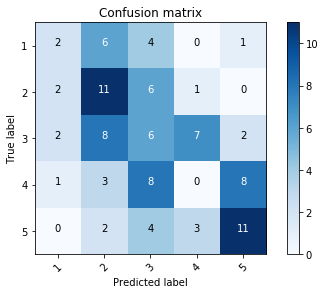

In [19]:
acc = mt.accuracy_score(y_test,ensemble_y_hat)
            #         lr_clf_accuracies.append(acc)
            #         cost_accuracies.append([acc])

ensemble_conf = mt.confusion_matrix(y_test,ensemble_y_hat)
plot_confusion_matrix(ensemble_conf, classes=[1, 2, 3, 4, 5])

Confusion matrix, without normalization
[[ 3  6  3  0  1]
 [ 6  5  8  0  1]
 [ 5  4 12  1  3]
 [ 1  1 11  1  6]
 [ 1  1  7  3  8]]


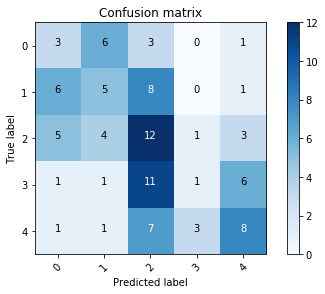

In [20]:
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
plot_confusion_matrix(mt.confusion_matrix(y_test, y_hat), classes=[0, 1, 2, 3, 4])

In [21]:
ensemble_score = get_confusion_costTot(ensemble_conf, cost_matrix)
ensemble_score

916

In [23]:
total_scores = []

estimators = ensemble.Ensemble.estimators_

for estimator in estimators:
    estimator_y_hat = estimator.predict(X_test)
    estimator_conf = mt.confusion_matrix(y_test, estimator_y_hat)
    score = get_confusion_costTot(estimator_conf, cost_matrix)
    total_scores.append(score)

In [24]:
print(total_scores)

[904, 910, 802, 909, 880, 979, 874, 942, 906, 975, 761, 912, 961, 923, 964, 979, 967, 914, 874, 910]


In [25]:
total_scores.append(ensemble_score)
print(total_scores)

[904, 910, 802, 909, 880, 979, 874, 942, 906, 975, 761, 912, 961, 923, 964, 979, 967, 914, 874, 910, 916]


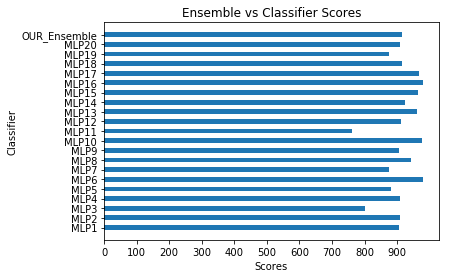

In [29]:
names = ('MLP1', 'MLP2', 'MLP3', 'MLP4', 'MLP5', 'MLP6', 'MLP7', 'MLP8', 'MLP9' ,'MLP10',
         'MLP11', 'MLP12', 'MLP13', 'MLP14', 'MLP15', 'MLP16', 'MLP17', 'MLP18', 'MLP19' ,'MLP20',"OUR_Ensemble")
yticks = [1,2,3,4,5,6,7,8,9,10,11, 12, 13, 14,15,16,17,18,19,20,21]
xticks = [0,100,200,300,400,500,600,700,800,900]

fig = plt.figure()
plt.barh(yticks,total_scores, 0.5)

plt.xlabel('Scores')
plt.ylabel('Classifier')
plt.yticks(yticks, names)
plt.xticks(xticks)
plt.title("Ensemble vs Classifier Scores")

We see that our Ensemble implementation neither outperforms or underperforms compared to a single classifier. This makes sense because our Esemble is a combination of all the predictions from the classifiers.

## Comparing ROCs and AUCs

### Ensemble Classifier

C:\Users\qvtra\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


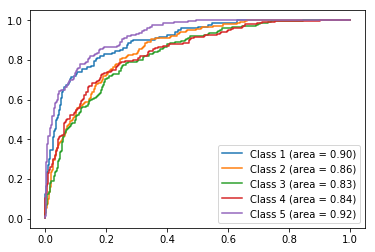

In [31]:
aucs = []
fprs = []
tprs = []
#classifier.fit(X_train,y_train)
#     probas = pipe_lr.fit(X_train[train],
#                          y_train[train]).predict_proba(X_train[test])
#     #ind_yhat = classifier.predict(X_test)
ind_yhat = ensemble.predict_proba(X_train)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
    # get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_train,
                                     ind_yhat[:,j-1],
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0 
    roc_auc += auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))
plt.figure()
for i in range(0,5):
    plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
               % (i+1, aucs[i]))
    plt.legend(loc='best')
#     perclass_mean_tpr /= len(classes)
#     roc_auc /= len(classes)
#     aucs.append(roc_auc)
#     mean_tpr += perclass_mean_tpr
#     plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold (area = %0.2f)'
#                    % ( roc_auc))
# #     mean_tpr /= K
#     mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
#                        % (mean_auc)`b)
#     plt.legend(loc='best')
plt.show()

C:\Users\qvtra\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


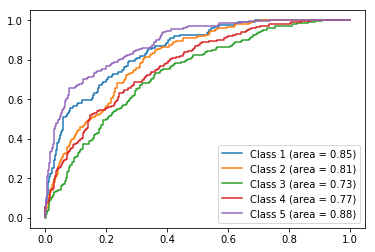

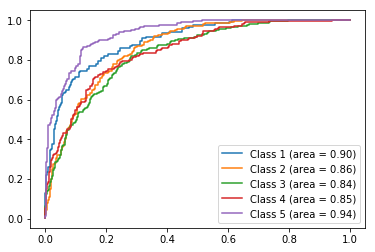

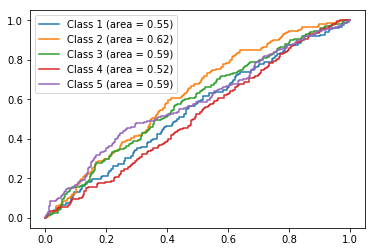

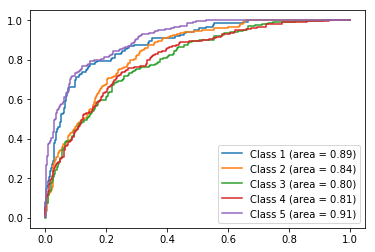

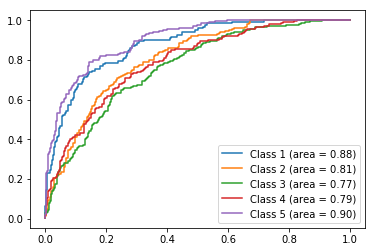

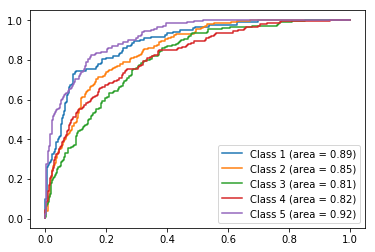

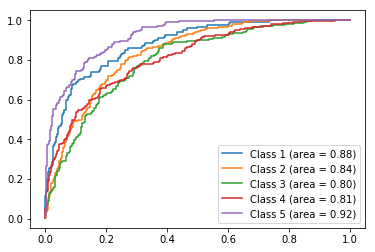

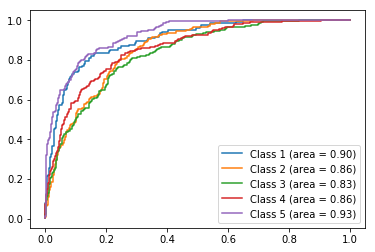

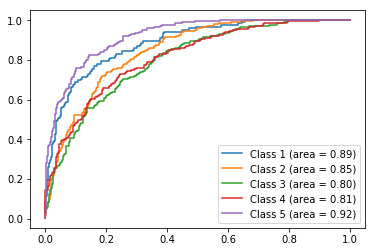

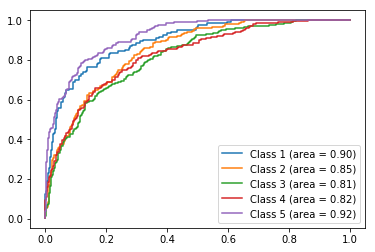

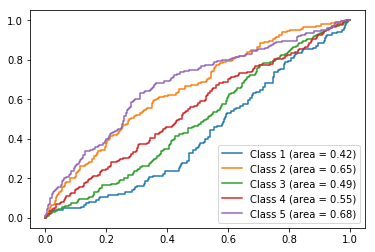

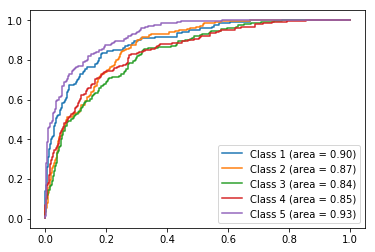

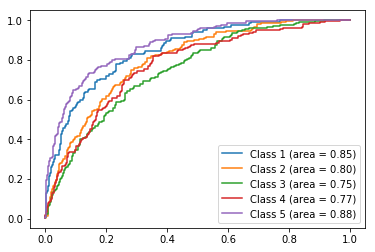

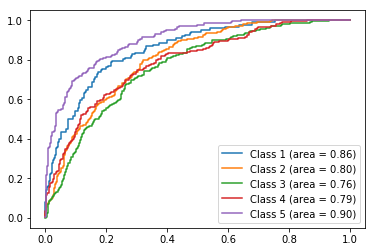

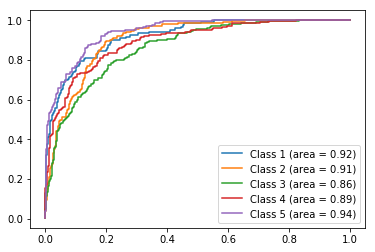

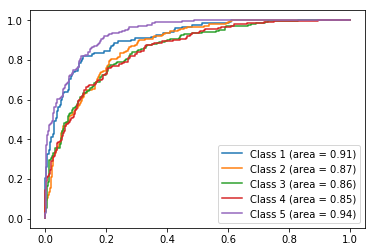

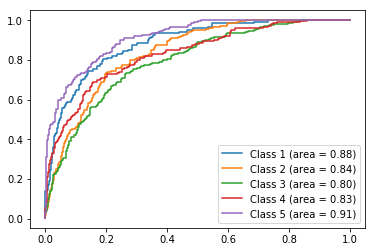

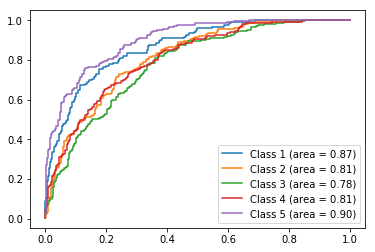

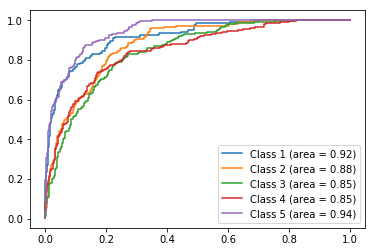

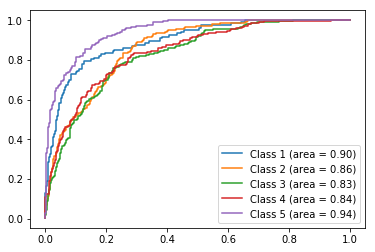

In [32]:
i = 0

for classifier in ensemble.Ensemble.estimators_:
    aucs = []
    fprs = []
    tprs = []
    #classifier.fit(X_train,y_train)
#     probas = pipe_lr.fit(X_train[train],
#                          y_train[train]).predict_proba(X_train[test])
#     #ind_yhat = classifier.predict(X_test)
    ind_yhat = classifier.predict_proba(X_train)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train)
        # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train,
                                         ind_yhat[:,j-1],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0 
        roc_auc += auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
    plt.figure()
    for i in range(0,5):
        plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
                   % (i+1, aucs[i]))
        plt.legend(loc='best')
#     perclass_mean_tpr /= len(classes)
#     roc_auc /= len(classes)
#     aucs.append(roc_auc)
#     mean_tpr += perclass_mean_tpr
#     plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold (area = %0.2f)'
#                    % ( roc_auc))
# #     mean_tpr /= K
#     mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
#                        % (mean_auc)`b)
#     plt.legend(loc='best')
    plt.show()


Based on the graphs, our ensemble classifier has better output quality than the individual classifiers due to the larger area under the curve for each of the classes, on an average of 0.03-0.06 difference, which indicates more points that are closer to the ideal point: a false positive rate of 0 and a true positive rate of 1.

### Exceptional Work

#### Proof showing dependence of classifiers

* Collecting the average base classifier error rate

In [35]:
from sklearn.metrics import accuracy_score

sum_error = 0
for classifiers in ensemble.Ensemble.estimators_:
    y_hat = classifiers.predict(X_test)
    sum_error += (1 - accuracy_score(y_test, y_hat))
error_rate = sum_error/20
print(error_rate)

0.688775510204


* Collecting the ensemble error rate

In [36]:
ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)
1 - accuracy_score(y_test, y_hat)

C:\Users\qvtra\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


0.67346938775510212

* Collecting the theoretical ensemble error rate assuming classifiers are independent

In [37]:
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/2.0)
    probs = [comb(n_classifier, k) *
            error**k *
            (1-error)**(n_classifier - k) for k in range (k_start, n_classifier + 1)]
    return(sum(probs))

In [38]:
ensemble_error(n_classifier=20, error=error_rate)


0.97731538338980473

The probability of the theoretical ensemble error rate assuming classifiers are independent is significantly different than the probability of our actual ensemble error rate. So we know that the classifiers are not independent, meaning that the errors that the models make overlap.

#### Logic as follows:

* Assume classifiers are independent

* if classifiers are independent, then ensemble error rate is k
    
* ensemble error rate is > k
    
* ensemble error rate is not k
    
* PROOF BY CONTRADICTION

<b>Classifiers are not independent.</b>

### Randomized Feature Selections

In [41]:
ensemble_random_sub_sampling = MyEnsemble(clf, num_estimators, y_train.shape[0],False)
ensemble_random_sub_sampling.fit_random(X_train,y_train)
r_ensemble_y_hat=ensemble_random_sub_sampling.predict(X_test)
print(mt.confusion_matrix(r_ensemble_y_hat,y_test))

C:\Users\qvtra\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\qvtra\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\qvtra\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\qvtra\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\qvtra\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-i

[[ 1  2  2  1  0]
 [ 7 10  7  3  2]
 [ 4  6  9  6  3]
 [ 0  0  5  1  4]
 [ 1  2  2  9 11]]


C:\Users\qvtra\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
